<a href="https://colab.research.google.com/github/itzrnvr/deeplearning-lab/blob/main/assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4: Mask R-CNN for Image Segmentation and GANs with MNIST

In [1]:
# Initial Setup: Import Libraries and Set Random Seeds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import glob
import random
import shutil
import zipfile
import requests
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.datasets import mnist

# For reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

## Google Colab File/Data Handling

This notebook is designed to run on Google Colab. You may need to upload datasets or mount your Google Drive for persistent storage. Use the following code cells to upload files or mount your Drive as needed.

In [2]:
# Upload files from your local machine
from google.colab import files
# files.upload()  # Uncomment to use

# Mount Google Drive
from google.colab import drive
# drive.mount('/content/drive')  # Uncomment to use

## Objective 1: Mask R-CNN for Image Segmentation on Blood Cell Dataset

### 1.1 Setup Mask R-CNN Environment (Matterport Implementation)

We will use the popular Matterport Mask R-CNN implementation for this task. The following steps will clone the repository and install the required dependencies. **Note:** These commands are intended for Google Colab and may require a runtime restart after installation.

In [3]:
# Clone and install Matterport Mask R-CNN (run in Colab)
# !git clone https://github.com/matterport/Mask_RCNN.git
# %cd Mask_RCNN
# !pip install -r requirements.txt
# !python setup.py install
# %cd ..
# # Import mrcnn modules AFTER installation
# import mrcnn.model as modellib
# from mrcnn.config import Config
# from mrcnn import visualize
# import mrcnn.utils as utils

### 1.2 Download Pre-trained COCO Weights

Download the pre-trained COCO weights for Mask R-CNN. These weights are required for inference.

In [4]:
# Download COCO weights
# coco_weights_path = "mask_rcnn_coco.h5"
# if not os.path.exists(coco_weights_path):
#     utils.download_trained_weights(coco_weights_path)
# print(f"COCO weights saved to: {coco_weights_path}")

### 1.3 Configure Mask R-CNN Model for Inference

Define a custom configuration for inference and initialize the Mask R-CNN model with pre-trained COCO weights.

In [5]:
# Define InferenceConfig and initialize model
# class InferenceConfig(Config):
#     NAME = "coco_inference"
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1
#     NUM_CLASSES = 1 + 80  # COCO has 80 classes
#     BATCH_SIZE = 1
#
# inference_config = InferenceConfig()
# inference_config.display()
#
# model = modellib.MaskRCNN(mode="inference",
#                           config=inference_config,
#                           model_dir="logs")
# model.load_weights(coco_weights_path, by_name=True)
#
# coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
#            'bus', 'train', 'truck', 'boat', 'traffic light',
#            'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
#            'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
#            'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
#            'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
#            'kite', 'baseball bat', 'baseball glove', 'skateboard',
#            'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
#            'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
#            'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
#            'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
#            'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
#            'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
#            'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
#            'teddy bear', 'hair drier', 'toothbrush']

### 1.4 Blood Cell Dataset Acquisition and Image Selection

**User Action Required:**
1. Go to: https://www.kaggle.com/datasets/paultimothymooney/blood-cells
2. Download the dataset (e.g., click "Download" button).
3. Upload the 'dataset2-master.zip' (or similar name) to your Colab environment.

The following code will extract the dataset and select 10 random images for segmentation.

In [6]:
# --- USER ACTION REQUIRED for Kaggle Dataset ---
# kaggle_zip_path = 'dataset2-master.zip'
# if os.path.exists(kaggle_zip_path):
#     with zipfile.ZipFile(kaggle_zip_path, 'r') as zip_ref:
#         zip_ref.extractall('blood_cell_dataset')
#     print("Blood cell dataset extracted.")
# else:
#     print(f"Please upload '{kaggle_zip_path}' to Colab and re-run this cell.")
#
# image_base_dir = 'blood_cell_dataset/dataset2-master/images/TRAIN/'
# all_image_paths = []
# if os.path.exists(image_base_dir):
#    for cell_type_folder in os.listdir(image_base_dir):
#        cell_type_path = os.path.join(image_base_dir, cell_type_folder)
#        if os.path.isdir(cell_type_path):
#            for fname in os.listdir(cell_type_path):
#                if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
#                    all_image_paths.append(os.path.join(cell_type_path, fname))
# else:
#    print(f"Dataset directory {image_base_dir} not found. Check extraction path.")
#
# if all_image_paths:
#    selected_image_paths = random.sample(all_image_paths, min(10, len(all_image_paths)))
#    print(f"Selected {len(selected_image_paths)} images for segmentation.")
# else:
#    selected_image_paths = []
#    print("No images found. Please check dataset path and structure.")

### 1.5 Run Segmentation and Visualize Results

The following code will run Mask R-CNN inference on the selected blood cell images and visualize the results. **Note:** Since we are using COCO weights, the model will attempt to segment COCO classes, not blood cells. Thus, the results may not correspond to actual blood cell types.

In [7]:
# for img_path in selected_image_paths:
#     try:
#         image = cv2.imread(img_path)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # mrcnn expects RGB
#
#         results = model.detect([image], verbose=0) # Set verbose=1 for more output
#         r = results[0]
#
#         visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],
#                                     coco_class_names, r['scores'],
#                                     title=f"Predictions for {os.path.basename(img_path)}")
#         plt.show()
#     except Exception as e:
#         print(f"Error processing {img_path}: {e}")

> **Note:** Since COCO weights are used, the model will try to segment COCO objects. Blood cells are not COCO classes, so it might segment parts of cells as "person" or other objects, or not segment them well. The task is to *generate predictions*, so this is expected.

## Objective 2: GAN for MNIST Image Generation

### 2.1 Load and Preprocess MNIST Dataset

We will use the MNIST dataset for training a DCGAN. Images are normalized to [-1, 1] for compatibility with the generator's tanh activation.

In [8]:
# Load and preprocess MNIST
from tensorflow.keras.datasets import mnist
(x_train, y_train), (_, _) = mnist.load_data()
# Normalize images to [-1, 1]
x_train = (x_train.astype('float32') - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=-1) # Add channel dimension
print(f"x_train shape: {x_train.shape}")

BUFFER_SIZE = x_train.shape[0]
BATCH_SIZE = 256 # Or 128
# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
x_train shape: (60000, 28, 28, 1)


### 2.2 Build Generator Model (DCGAN)

The generator takes a latent vector and outputs a 28x28x1 image.

In [9]:
from keras.layers import Dense, Conv2D, Flatten, Reshape, LeakyReLU, Dropout, BatchNormalization, Conv2DTranspose

latent_dim = 100

def build_generator(latent_dim):
    model = Sequential([
        Dense(7*7*256, use_bias=False, input_shape=(latent_dim,)),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 256)),

        Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        BatchNormalization(),
        LeakyReLU(),

        Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator(latent_dim)
generator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

### 2.3 Build Discriminator Model (DCGAN)

The discriminator takes a 28x28x1 image and outputs a probability (real/fake).

In [10]:
def build_discriminator():
    model = Sequential([
        Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        LeakyReLU(),
        Dropout(0.3),

        Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(),
        Dropout(0.3),

        Flatten(),
        Dense(1) # No sigmoid here, using from_logits=True in loss
    ])
    return model

discriminator = build_discriminator()
discriminator.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

### 2.4 Define Loss Functions and Optimizers

We use binary cross-entropy loss and Adam optimizers for both generator and discriminator.

In [11]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### 2.5 Define Training Step

The following function performs a single training step for the GAN using `tf.GradientTape`.

In [12]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

### 2.6 Training Loop and Image Generation

The following code defines the training loop and periodically generates sample images from the generator.

Epoch 1, Gen Loss: 0.9171, Disc Loss: 0.8672
Epoch 2, Gen Loss: 0.8641, Disc Loss: 1.2484
Epoch 3, Gen Loss: 0.8842, Disc Loss: 1.1840
Epoch 4, Gen Loss: 0.8649, Disc Loss: 1.2571


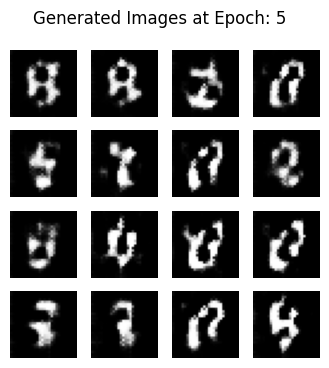

Epoch 5, Gen Loss: 0.9362, Disc Loss: 1.2529
Epoch 6, Gen Loss: 0.7972, Disc Loss: 1.3251
Epoch 7, Gen Loss: 0.8551, Disc Loss: 1.2458
Epoch 8, Gen Loss: 0.8593, Disc Loss: 1.2928
Epoch 9, Gen Loss: 0.9294, Disc Loss: 1.2381


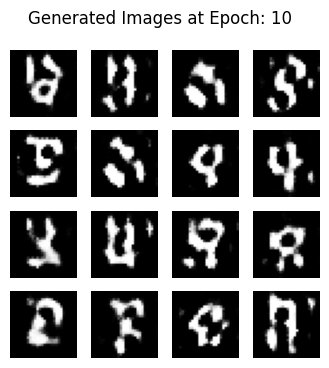

Epoch 10, Gen Loss: 0.9500, Disc Loss: 1.2031
Epoch 11, Gen Loss: 0.9110, Disc Loss: 1.2108
Epoch 12, Gen Loss: 1.0222, Disc Loss: 1.1806
Epoch 13, Gen Loss: 1.0229, Disc Loss: 1.1554
Epoch 14, Gen Loss: 1.0430, Disc Loss: 1.1410


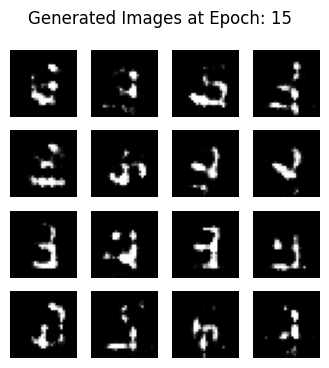

Epoch 15, Gen Loss: 1.0444, Disc Loss: 1.1656
Epoch 16, Gen Loss: 1.2005, Disc Loss: 1.0290
Epoch 17, Gen Loss: 1.1583, Disc Loss: 1.1337
Epoch 18, Gen Loss: 1.1480, Disc Loss: 1.0520
Epoch 19, Gen Loss: 1.1804, Disc Loss: 1.0452


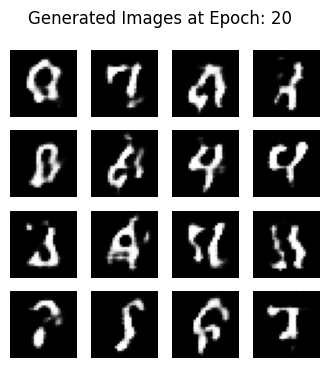

Epoch 20, Gen Loss: 1.1314, Disc Loss: 1.1101
Epoch 21, Gen Loss: 1.1782, Disc Loss: 1.0656
Epoch 22, Gen Loss: 1.1559, Disc Loss: 1.0745
Epoch 23, Gen Loss: 1.2149, Disc Loss: 1.0528
Epoch 24, Gen Loss: 1.3192, Disc Loss: 0.9852


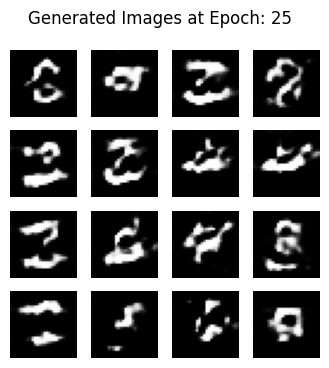

Epoch 25, Gen Loss: 1.3639, Disc Loss: 0.9943
Epoch 26, Gen Loss: 1.4507, Disc Loss: 0.9353
Epoch 27, Gen Loss: 1.2811, Disc Loss: 1.0384
Epoch 28, Gen Loss: 1.1587, Disc Loss: 1.1004
Epoch 29, Gen Loss: 1.1244, Disc Loss: 1.1190


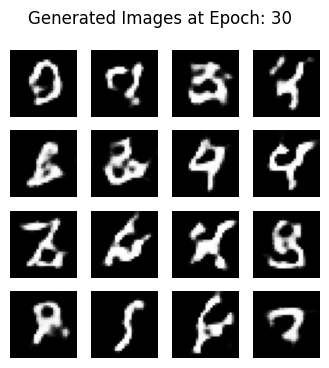

Epoch 30, Gen Loss: 1.1097, Disc Loss: 1.1426
Epoch 31, Gen Loss: 1.1146, Disc Loss: 1.1404
Epoch 32, Gen Loss: 1.0858, Disc Loss: 1.1526
Epoch 33, Gen Loss: 1.0814, Disc Loss: 1.1741
Epoch 34, Gen Loss: 1.0922, Disc Loss: 1.1680


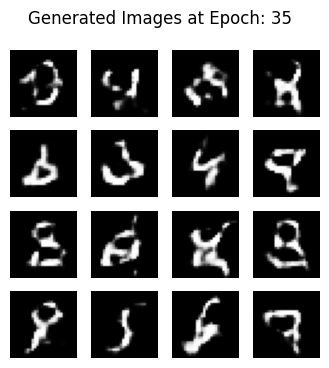

Epoch 35, Gen Loss: 1.1238, Disc Loss: 1.1580
Epoch 36, Gen Loss: 1.1258, Disc Loss: 1.1325
Epoch 37, Gen Loss: 1.0341, Disc Loss: 1.1944
Epoch 38, Gen Loss: 1.0009, Disc Loss: 1.2028
Epoch 39, Gen Loss: 0.9729, Disc Loss: 1.2049


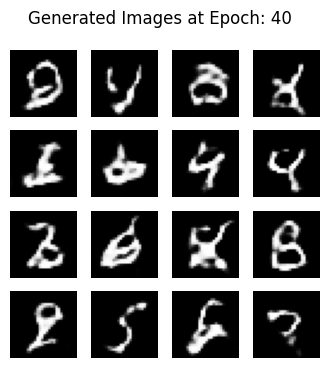

Epoch 40, Gen Loss: 0.9805, Disc Loss: 1.2111
Epoch 41, Gen Loss: 0.9831, Disc Loss: 1.2125
Epoch 42, Gen Loss: 0.9753, Disc Loss: 1.2313
Epoch 43, Gen Loss: 1.0227, Disc Loss: 1.2077
Epoch 44, Gen Loss: 0.9749, Disc Loss: 1.2261


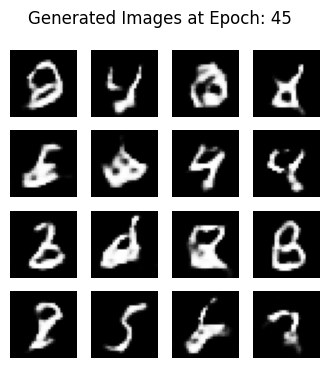

Epoch 45, Gen Loss: 0.9342, Disc Loss: 1.2404
Epoch 46, Gen Loss: 0.9515, Disc Loss: 1.2273
Epoch 47, Gen Loss: 1.0129, Disc Loss: 1.2142
Epoch 48, Gen Loss: 1.0390, Disc Loss: 1.1804
Epoch 49, Gen Loss: 0.9723, Disc Loss: 1.2389


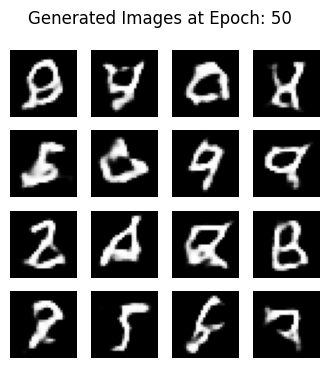

Epoch 50, Gen Loss: 0.9553, Disc Loss: 1.2367


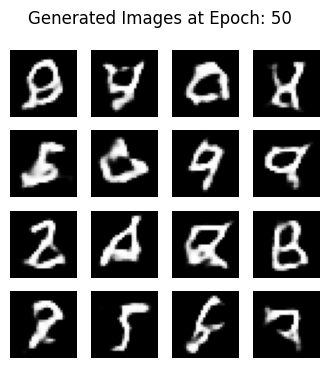

In [13]:
EPOCHS = 50 # Start with fewer epochs for quick run, e.g., 20-50
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, latent_dim]) # Fixed noise for consistent generation

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray') # Denormalize
        plt.axis('off')
    plt.suptitle(f"Generated Images at Epoch: {epoch}")
    plt.show()

def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_epoch = []
        disc_loss_epoch = []
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)
            gen_loss_epoch.append(g_loss.numpy())
            disc_loss_epoch.append(d_loss.numpy())

        # Produce images for the GIF as we go
        if (epoch + 1) % 5 == 0: # Generate every 5 epochs
            generate_and_save_images(generator, epoch + 1, seed)

        print(f'Epoch {epoch+1}, Gen Loss: {np.mean(gen_loss_epoch):.4f}, Disc Loss: {np.mean(disc_loss_epoch):.4f}')

    # Generate after the final epoch
    generate_and_save_images(generator, epochs, seed)

# Start training
train(train_dataset, EPOCHS)

#### Note on GANs for Classification:

While this implementation focuses on image generation with a DCGAN, GAN architectures like AC-GAN (Auxiliary Classifier GAN) or SGAN (Semi-Supervised GAN) can be used for classification tasks. In an AC-GAN, the discriminator also predicts class labels. For this assignment, we've implemented a standard generative GAN as per the common interpretation of the hint.

---

End of Assignment 4.